In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mne
import os

In [2]:
montage = mne.channels.read_custom_montage('./BC-MR3-64.bvef')

In [3]:
# Get active and sham groups from main csv
df = pd.read_csv('../joint/msc_collated_data_20230709.csv')
df = df[["participant_number", "session_type"]].drop_duplicates()

def remove_doubles(x):
    if(x.nunique()==2):
        return 'sham group'
    elif(x.nunique()==1):
        return 'active group'

df["condition"] = df.groupby('participant_number')['session_type'].transform(remove_doubles)
df = df.drop(columns="session_type").drop_duplicates()
df['participant_number'] = df['participant_number'].replace(r'sub-', r'm_', regex=True)

active_ids = df[df.condition=='active group'].participant_number.to_list()
sham_ids = df[df.condition=='sham group'].participant_number.to_list()
# active_ids, sham_ids

In [5]:
# Get list of filenames for each group:
cleaned_dir = './ica_notebooks/cleaned'

active_eeg_files = []
sham_eeg_files = []

for root, dirs, files in os.walk(cleaned_dir):
    for file in files:
        # Actives
        if file.endswith('.vhdr') and any(id in file for id in active_ids):
            active_eeg_files.append(os.path.join(root, file))
        # Sham 
        elif file.endswith('.vhdr') and any(id in file for id in sham_ids):
            sham_eeg_files.append(os.path.join(root, file))

active2bs = []
active2as = []
active1as = []
active1bs = []

sham2bs = []
sham2as = []
sham1as = []
sham1bs = []

# Just look at Posner 2b
for x in active_eeg_files:
    if 'pos2b' in x:
        active2bs.append(x)
    if 'pos1a' in x:
        active1as.append(x)
    if 'pos1b' in x:
        active1bs.append(x)
    if 'pos2a' in x:
        active2as.append(x)
for x in sham_eeg_files:
    if 'pos2b' in x:
        sham2bs.append(x)
    if 'pos1a' in x:
        sham1as.append(x)
    if 'pos1b' in x:
        sham1bs.append(x)
    if 'pos2a' in x:
        sham2as.append(x)

active2bs, sham2bs

(['./cleaned/m_09_02/m_09_02_pos2b.vhdr',
  './cleaned/m_19_02/m_19_02_pos2b.vhdr',
  './cleaned/m_07_02/m_07_02_pos2b.vhdr',
  './cleaned/m_03_02/m_03_02_pos2b.vhdr',
  './cleaned/m_16_02/m_16_02_pos2b.vhdr',
  './cleaned/m_11_02/m_11_02_pos2b.vhdr',
  './cleaned/m_15_02/m_15_02_pos2b.vhdr',
  './cleaned/m_20_02/m_20_02_pos2b.vhdr',
  './cleaned/m_14_02/m_14_02_pos2b.vhdr',
  './cleaned/m_00_02/m_00_02_pos2b.vhdr',
  './cleaned/m_10_02/m_10_02_pos2b.vhdr'],
 ['./cleaned/m_08_02/m_08_02_pos2b.vhdr',
  './cleaned/m_18_02/m_18_02_pos2b.vhdr',
  './cleaned/m_17_02/m_17_02_pos2b.vhdr',
  './cleaned/m_13_02/m_13_02_pos2b.vhdr',
  './cleaned/m_02_02/m_02_02_pos2b.vhdr',
  './cleaned/m_12_02/m_12_02_pos2b.vhdr',
  './cleaned/m_06_02/m_06_02_pos2b.vhdr',
  './cleaned/m_01_02/m_01_02_pos2b.vhdr',
  './cleaned/m_05_02/m_05_02_pos2b.vhdr',
  './cleaned/m_04_02/m_04_02_pos2b.vhdr'])

In [6]:
event_map = {'Comment/101':101, 
             'Comment/109':109,
             'Comment/30':30,
             'Comment/40':40,
             'Comment/50':50,
             'Comment/51':51,
             'Comment/52':52,
             'Comment/60':60,
             'Comment/70':70,
             'Comment/80':80,
             'New Segment/':99999}

# Analysis

In [7]:
# Define the frequency bands of interest
freqs = np.logspace(*np.log10([3, 30]), num=8)  # alpha to gamma frequencies
# freqs = np.arange(7, 20, 2)
n_cycles = freqs / 2.  # different number of cycle per frequency

In [14]:
def process_group(file_names, focal_event):
    # epoch_list = []
    powers = list()
    for file in file_names:
        # Load raw
        raw = mne.io.read_raw(file, preload=True)
        print('dropping channel');raw.drop_channels('ECG')
        # Filter ?
        filt_raw = raw.copy().filter(l_freq=1.0, h_freq=40)
        # Events
        events, event_id = mne.events_from_annotations(filt_raw, event_map) # get events
        # Re-reference
        avg_ref = raw.copy().set_eeg_reference(ref_channels="average")
        # Get epochs
        epochs = mne.Epochs(raw=avg_ref, 
                            events=events, 
                            event_id={'valid stim':focal_event}, 
                            detrend=1, 
                            tmin=-.3, 
                            tmax=1, 
                            baseline=(-0.3, -0.1),
                            preload=True,
                            # picks=picks,
                            event_repeated='drop')

        epochs.set_montage(montage)
        # test_epochs.plot(events=test_events)
        power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=1) # get tfr_morlet
        power.info.set_montage(montage) # set_montage
        powers.append(power)
    return powers

## Central cues

In [9]:
active_powers = process_group(active2bs, 80)
# Average the TFR representations over epochs for each group
average_power_active = mne.grand_average(active_powers)

Extracting parameters from ./cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
20 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
36 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
38 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
38 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
27 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_11_02/m_11_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 676999  =      0.000 ...   676.999 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    1.1s finished


Not setting metadata
40 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
35 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
22 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
32 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
29 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
36 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Identifying common channels ...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/3145096590.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


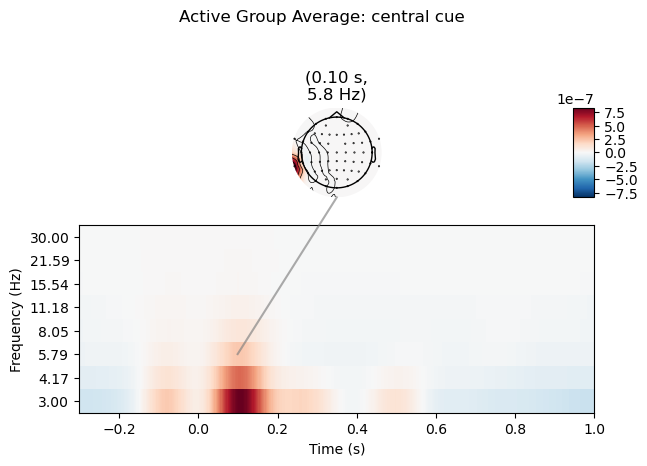

In [13]:
# Plot the result
average_power_active.plot_joint(baseline=(-0.3,-.01), mode='mean', title='Active Group Average: central cue', timefreqs=[(0.1, 6)]);
# Show
plt.show()

## Right cues

In [15]:
active_powers_right = process_group(active2bs, 70)
# Average the TFR representations over epochs for each group
average_power_active_right = mne.grand_average(active_powers_right)

Extracting parameters from ./cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
26 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 26 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_11_02/m_11_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 676999  =      0.000 ...   676.999 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
32 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Identifying common channels ...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


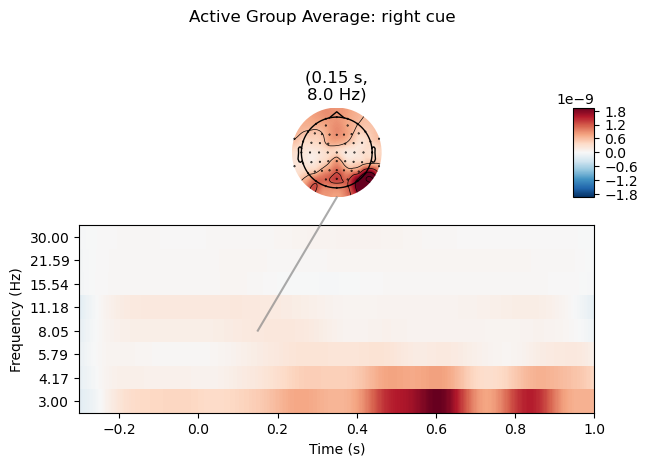

In [16]:
# Plot the result for each group
average_power_active_right.plot_joint(baseline=(-0.3, -0.2), mode='mean', title='Active Group Average: right cue', timefreqs=[(0.15, 9)]);
# Show
plt.show()

### Left cues

In [17]:
active_powers_left = process_group(active2bs, 60)
# Average the TFR representations over epochs for each group
average_power_active_left = mne.grand_average(active_powers_left)

Extracting parameters from ./cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
38 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
34 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_11_02/m_11_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 676999  =      0.000 ...   676.999 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
39 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
32 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Identifying common channels ...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


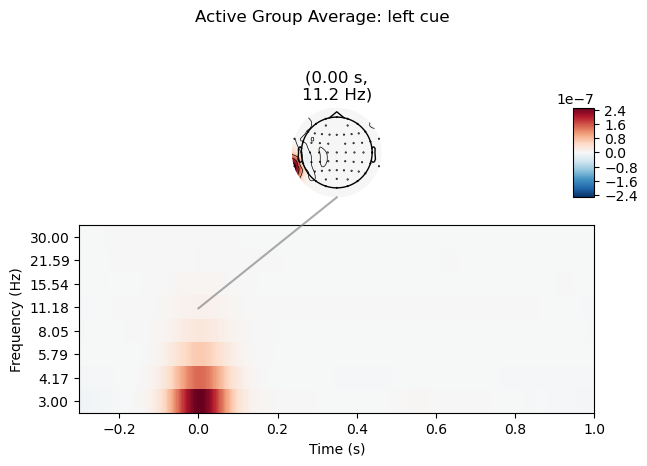

In [25]:
# Plot the result for each group
average_power_active_left.plot_joint(baseline=(-0.3, -0.1), mode='mean', title='Active Group Average: left cue', timefreqs=(0, 10));
# Show
plt.show()

# Sham group

In [19]:
sham_powers_right = process_group(sham2bs, 70)
sham_power_right_avg = mne.grand_average(sham_powers_right)

Extracting parameters from ./cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
25 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_06_02/m_06_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 704462  =      0.000 ...   704.462 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
42 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 42 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Identifying common channels ...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


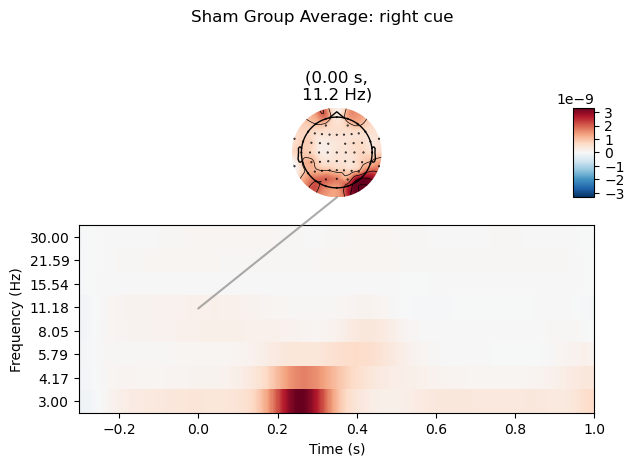

In [20]:
# Plot the result for each group
sham_power_right_avg.plot_joint(baseline=(-0.3, -0.2), mode='mean', title='Sham Group Average: right cue', timefreqs=[(0, 10)]);
# Show
plt.show()

In [21]:
sham_powers_left = process_group(sham2bs, 60)

sham_power_left_avg = mne.grand_average(sham_powers_left)

Extracting parameters from ./cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.9s finished


Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
39 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    1.0s finished


Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_06_02/m_06_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 704462  =      0.000 ...   704.462 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.9s finished


Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Identifying common channels ...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_71263/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


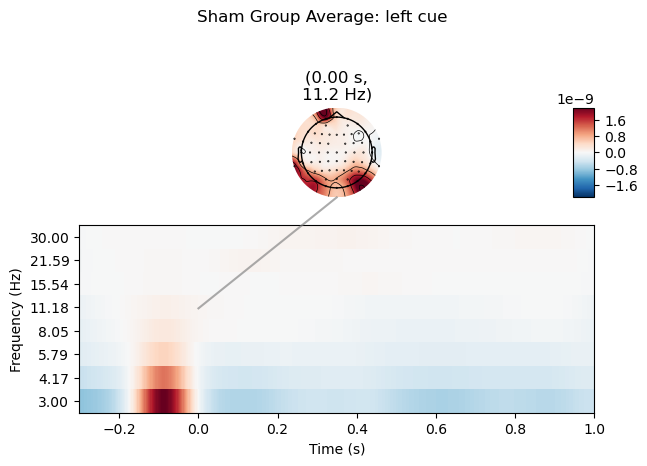

In [22]:
# Plot the result for each group
sham_power_left_avg.plot_joint(baseline=(-0.3, -0.1), mode='mean', title='Sham Group Average: left cue', timefreqs=[(0, 10)]);
# Show
plt.show()

In [106]:
sham_powers_centre = process_group(sham2bs, 80)

sham_power_centre_avg = mne.grand_average(sham_powers_centre)

Extracting parameters from ./cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 1301 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
52 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 52 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
45 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 45 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
32 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
25 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_06_02/m_06_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 704462  =      0.000 ...   704.462 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
39 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
37 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
43 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 43 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Identifying common channels ...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/1776921520.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


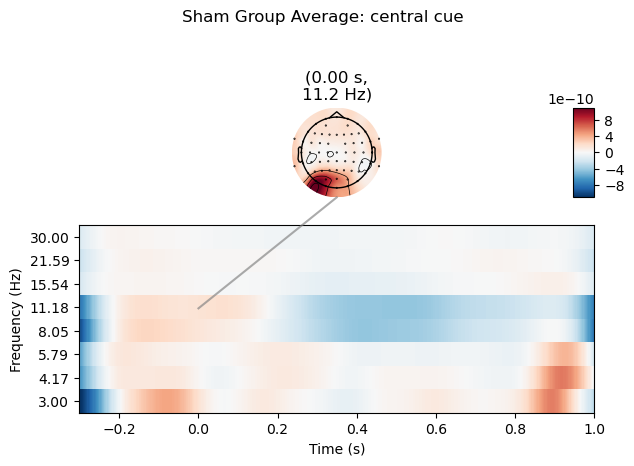

In [110]:
# Plot the result for each group
sham_power_centre_avg.plot_joint(baseline=(-0.3, 0), mode='mean', title='Sham Group Average: central cue', timefreqs=[(0, 10)]);
# Show
plt.show()

# Testing

In [8]:
active2bs

['./cleaned/m_09_02/m_09_02_pos2b.vhdr',
 './cleaned/m_19_02/m_19_02_pos2b.vhdr',
 './cleaned/m_07_02/m_07_02_pos2b.vhdr',
 './cleaned/m_03_02/m_03_02_pos2b.vhdr',
 './cleaned/m_16_02/m_16_02_pos2b.vhdr',
 './cleaned/m_11_02/m_11_02_pos2b.vhdr',
 './cleaned/m_15_02/m_15_02_pos2b.vhdr',
 './cleaned/m_20_02/m_20_02_pos2b.vhdr',
 './cleaned/m_14_02/m_14_02_pos2b.vhdr',
 './cleaned/m_00_02/m_00_02_pos2b.vhdr',
 './cleaned/m_10_02/m_10_02_pos2b.vhdr']

In [61]:
del test_avg
del test_sample

In [146]:
# test_list = active2bs
# test_list.pop(0)
subject = [active2bs[6]]
# subject = test_list
print(subject)
test_sample = process_group(subject, 60)
test_avg = mne.grand_average(test_sample)
# Plot the result for each group
test_avg.plot_joint(baseline=(-0.2,-0.15), mode='mean', title='Test', timefreqs=[(0.1, 11)]);
# Show
plt.show()

['./cleaned/m_15_02/m_15_02_pos2b.vhdr']
Extracting parameters from ./cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_37203/3582975314.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_37203/3582975314.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


TypeError: All elements must be an instance of Evoked or AverageTFR, got <class 'list'> instead.

In [83]:
eyes1=mne.io.read_raw(active2bs[0])
eyes1.plot()

Extracting parameters from ./cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Using pyopengl with version 3.1.6


Channels marked as bad:
none


# Non-parametric between conditions cluster statistics on singer trial power

In [57]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_test
from mne.datasets import sample

In [71]:
def gather_epochs(file_names, focal_event):
    epochs_list = []
    for file in file_names:
        # Load raw
        raw = mne.io.read_raw(file, preload=True)
        print('dropping channel');raw.drop_channels('ECG')
        # Filter ?
        filt_raw = raw.copy().filter(l_freq=1.0, h_freq=40)
        # Events
        events, event_id = mne.events_from_annotations(filt_raw, event_map) # get events
        # Re-reference
        avg_ref = raw.copy().set_eeg_reference(ref_channels="average")
        # Get epochs
        epochs = mne.Epochs(raw=avg_ref, 
                            events=events, 
                            event_id={'cue':focal_event}, 
                            detrend=1, 
                            tmin=-.3, 
                            tmax=1, 
                            baseline=(-0.3, -0.1),
                            preload=True,
                            # picks=picks,
                            event_repeated='drop')

        epochs.set_montage(montage)
        epochs_list.append(epochs)

    return epochs_list

In [95]:
active_epochs_left = gather_epochs(active2bs, 60)

Extracting parameters from ./cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
38 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
34 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_11_02/m_11_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 676999  =      0.000 ...   676.999 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
39 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
32 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
33 matching events found


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


In [73]:
sham_epochs_left=gather_epochs(sham2bs, 60)

Extracting parameters from ./cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 1301 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
33 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
39 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_06_02/m_06_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 704462  =      0.000 ...   704.462 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 1301 original time points ...
0 bad epochs dropped
Extracting parameters from ./cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 1301 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/3122049619.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


In [145]:
sham_epochs_left_con = mne.concatenate_epochs(sham_epochs_left).pick_channels(['PO7'])
active_epochs_left_con = mne.concatenate_epochs(active_epochs_left).pick_channels(['PO7'])

Not setting metadata
303 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
361 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/243164425.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sham_epochs_left_con = mne.concatenate_epochs(sham_epochs_left).pick_channels(['PO7'])
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_55496/243164425.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  active_epochs_left_con = mne.concatenate_epochs(active_epochs_left).pick_channels(['PO7'])


In [146]:
decim = 2
freqs = np.arange(7, 30, 3)  # define frequencies of interest
n_cycles = 1.5

tfr_epochs_1 = tfr_morlet(
    active_epochs_left_con,
    freqs,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=False,
    average=False,
)

tfr_epochs_2 = tfr_morlet(
    sham_epochs_left_con,
    freqs,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=False,
    average=False,
)

tfr_epochs_1.apply_baseline(mode="ratio", baseline=(None, 0))
tfr_epochs_2.apply_baseline(mode="ratio", baseline=(None, 0))

epochs_power_1 = tfr_epochs_1.data[:, 0, :, :]  # only 1 channel as 3D matrix
epochs_power_2 = tfr_epochs_2.data[:, 0, :, :]  # only 1 channel as 3D matrix

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [147]:
threshold = 6.0
F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    [epochs_power_1, epochs_power_2],
    out_type="mask",
    n_permutations=100,
    threshold=threshold,
    tail=0,
)

stat_fun(H1): min=0.000000 max=11.283134
Running initial clustering …
Found 9 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Need more than one channel to make topography for eeg. Disabling interactivity.


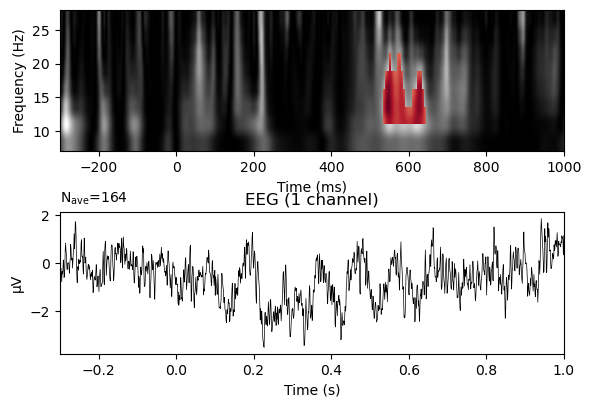

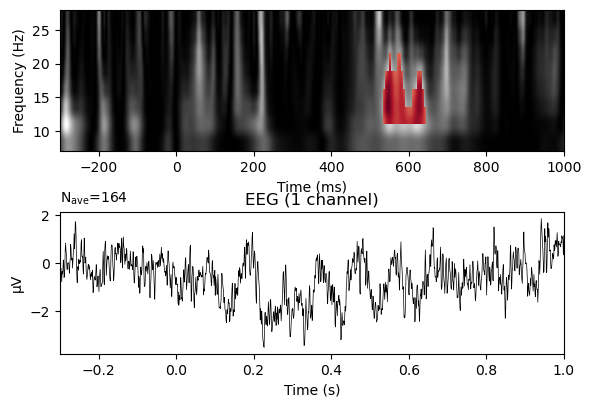

In [148]:
times = 1e3 * active_epochs_left_con.times  # change unit to ms

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
fig.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

# Compute the difference in evoked to determine which was greater since
# we used a 1-way ANOVA which tested for a difference in population means
evoked_power_1 = epochs_power_1.mean(axis=0)
evoked_power_2 = epochs_power_2.mean(axis=0)
evoked_power_contrast = evoked_power_1 - evoked_power_2
signs = np.sign(evoked_power_contrast)

# Create new stats image with only significant clusters
F_obs_plot = np.nan * np.ones_like(F_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        F_obs_plot[c] = F_obs[c] * signs[c]

ax.imshow(
    F_obs,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="gray",
)
max_F = np.nanmax(abs(F_obs_plot))
ax.imshow(
    F_obs_plot,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
    vmin=-max_F,
    vmax=max_F,
)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Frequency (Hz)")
# ax.set_title(f"Induced power ({ch_name})")

# plot evoked
evoked_condition_1 = active_epochs_left_con.average()
evoked_condition_2 = sham_epochs_left_con.average()
evoked_contrast = mne.combine_evoked(
    [evoked_condition_1, evoked_condition_2], weights=[1, -1]
)
evoked_contrast.plot(axes=ax2, time_unit="s")